In [96]:
import numpy as np
import scipy as sp
import scipy.fftpack
from matplotlib import pyplot as plt
import scipy.io
import lib

In [97]:
rootfolder = '..'

Generating 1-D DCT basis
------------------------


In [98]:
M = 128 # signal dimension
N = M # nr of atoms in the basis (this will be different when using redundant set of generators)

D = np.zeros((M, N)) # matrix containing the DCT basis (a DCT function in each column)
DCT = lib.dct_matrix(M)
DCT.shape

(128, 128)

Display an atom of the dct basis

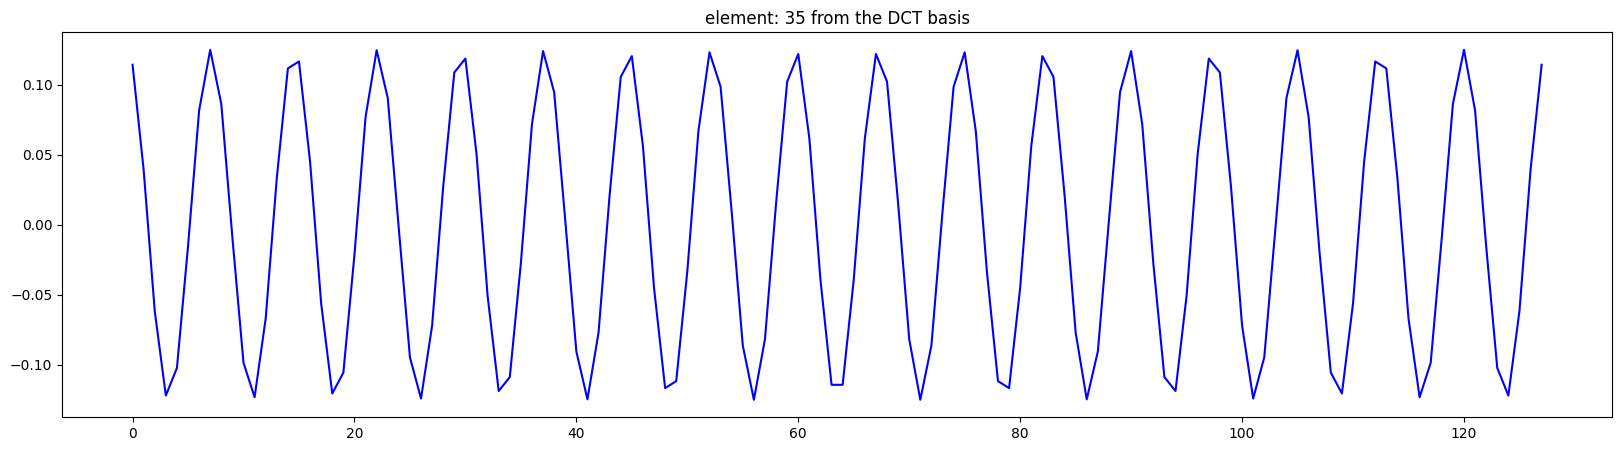

In [99]:
k = 34
plt.figure(figsize=(20, 5))
plt.plot(DCT[:, k], 'b')
plt.title(f'element: {k+1} from the DCT basis');

Check orthogonality

In [100]:
is_DCT_orth = np.allclose(DCT.T @ DCT, np.eye(M))
print(f'DCT dictionary is orthogonal: {is_DCT_orth}')

DCT dictionary is orthogonal: True


Display the basis in the matrix

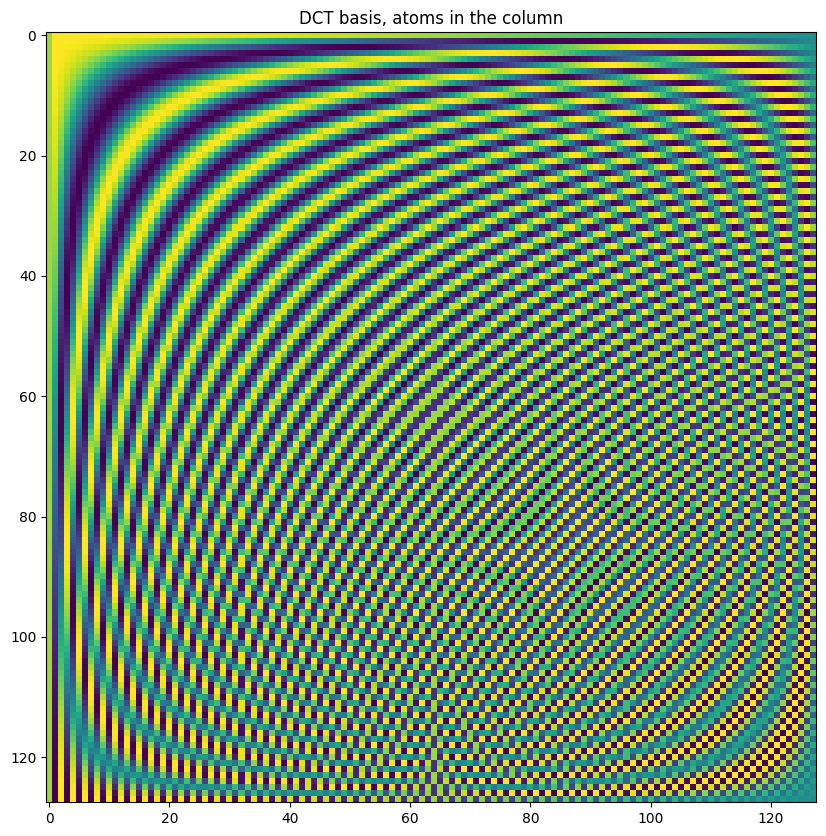

In [101]:
plt.figure(figsize=(10,10))
plt.imshow(DCT)
plt.title('DCT basis, atoms in the column');

Generate 1D DCT basis using the function idct
---------------------------------------------
idct is the inverse dct transform stack this in the matrix D

In [102]:
# for k in range(M):
#     # define the atom
#     a = np.zeros(M)
#     a[k] = 1
#     D[:, k] = sp.fftpack.idct(a, norm='ortho')
D = sp.fftpack.idct(np.eye(M), norm='ortho', axis=0)
D.shape

(128, 128)

Display the basis in the matrix

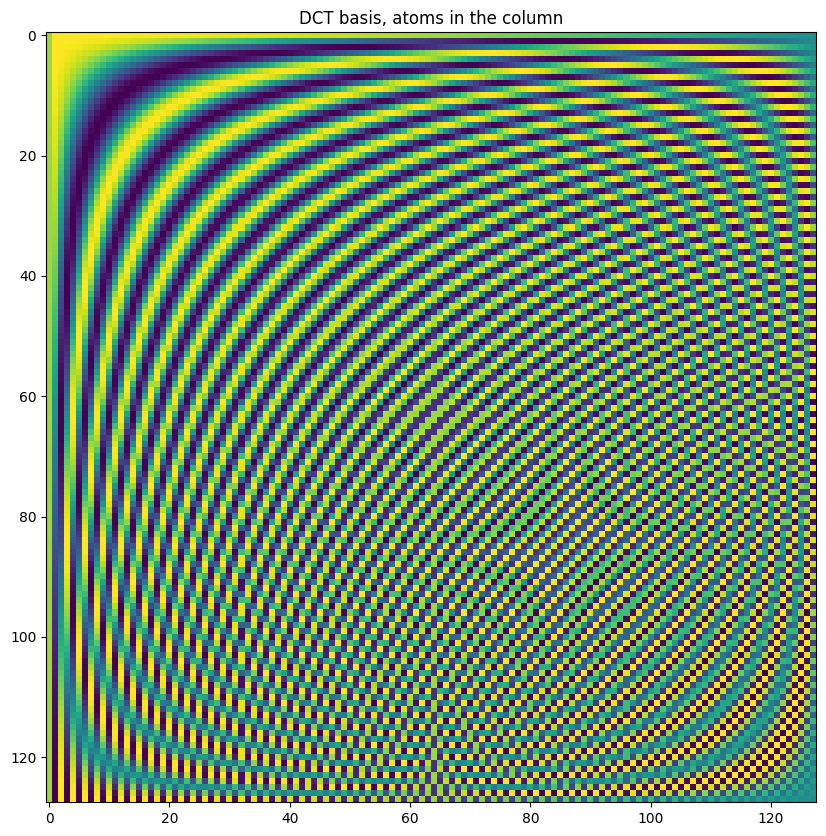

In [103]:
plt.figure(figsize=(10,10))
plt.imshow(DCT)
plt.title('DCT basis, atoms in the column');

Check that D and DCT defined above coincide

In [104]:
is_DCT_equal_D = np.allclose(D, DCT)
print(f'D and DCT are equal: {is_DCT_equal_D}')

D and DCT are equal: True


Analysis: compute the representation of an input ECG signal
-----------------------------------------------------------
Load few ECG signals to be processed

In [105]:
temp = scipy.io.loadmat(f'{rootfolder}/data/croppedECG.mat')
nBeats = 10
S = temp['S'][:, :nBeats]
# X = np.zeros((M, nBeats)) # initialize the matrix of representations of S w.r.t. D

Compute the representation coefficients

In [106]:
X = D.T @ S
X.shape

(128, 10)

Display a signal and its representation coefficients

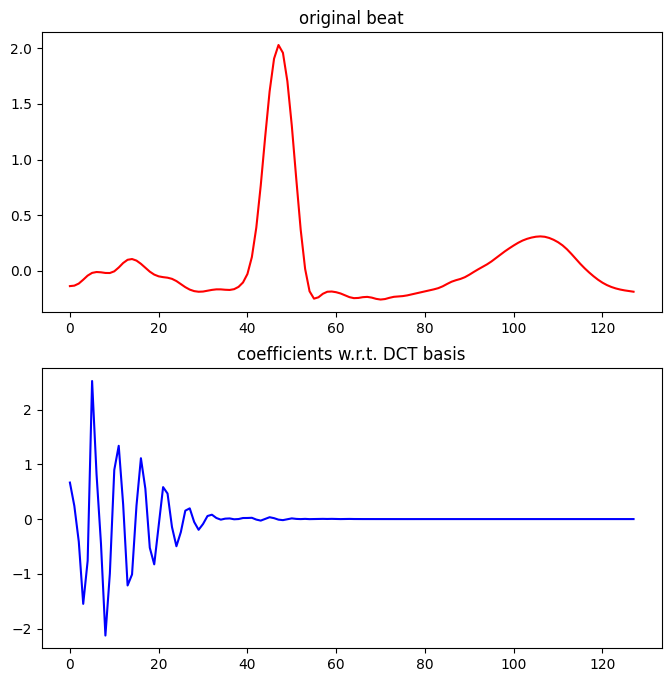

In [107]:
i = 5
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(S[:, i], 'r')
ax1.set_title('original beat')
ax2.plot(X[:, i], 'b')
ax2.set_title('coefficients w.r.t. DCT basis');

Synthesis: reconstruct all the ECG signals from their representations
---------------------------------------------------------------------
Reconstruct the two signals (express them w.r.t. the standard basis)

In [108]:
S_hat_D = D @ X
S_hat_D.shape

(128, 10)

Check if there is perfect reconstruction.

It is trivial because $\hat S_D = DD^TS$ and $DD^T = I_M$  since $D$ is orthonormal (the same applies to $C$)

In [109]:
is_reconstruction_perfect = np.allclose(S, S_hat_D)
print(f'The reconstruction is perfect: {is_reconstruction_perfect}')

The reconstruction is perfect: True


Add noise to ECG data and inspect the representations
-----------------------------------------------------


In [110]:
sigma_noise = 0.1
S0 = S.copy()
S = S0 + sigma_noise * np.random.normal(size=S0.shape)
# X = np.zeros((M, nBeats)) # initialize the matrix of representations of S w.r.t. D

Compute the representation coefficients

In [111]:
X = D.T @ S
X.shape

(128, 10)

Display a signal and its representation coefficients

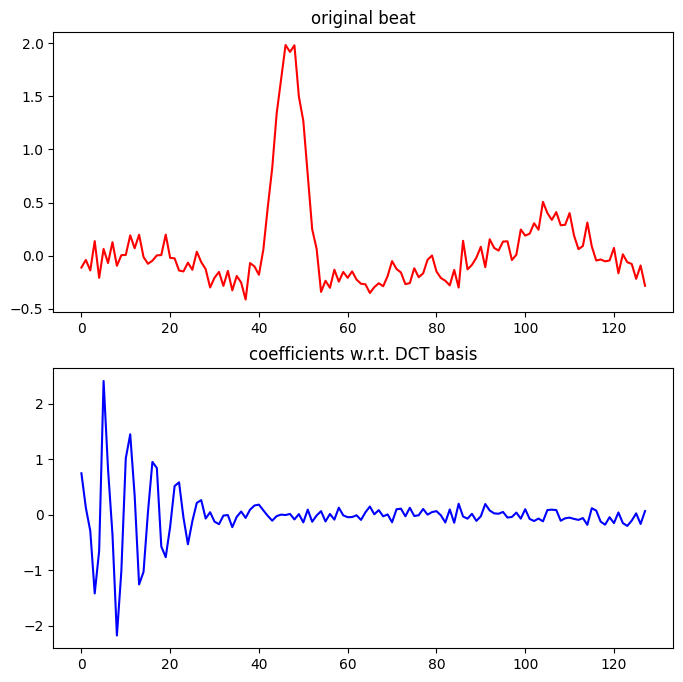

In [112]:
i = 5
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
ax1.plot(S[:, i], 'r')
ax1.set_title('original beat')
ax2.plot(X[:, i], 'b')
ax2.set_title('coefficients w.r.t. DCT basis');

Hard Thresholding
-----------------
Noise affects all the coefficients of our transformation

Keep only $L$ coefficients having largest magnitude

In [113]:
# X_HT = np.zeros((M, nBeats)) # initialize the matrix of representations of S w.r.t. D
# S_hat = np.zeros((M, nBeats))
# L = 21 # sparsity level (try different values)

# for i in range(nBeats):
#     origSignal = #
#     noisySignal = #

#     # transform each signal separately (analysis)
#     x = #

#     # keep only the L largest coefficients (absolute value)
#     x_HT[:, i] = #

#     # invert the transformation
#     s_hat = #

#     S_hat[:, i] = s_hat

In [117]:
def denoise(X, L):
    to_cut = np.argsort(X, axis=0)[:-L, :]
    X_HT = X.copy()
    X_HT[to_cut] = 0
    return D @ X_HT, X_HT

In [118]:
L = 21
S_hat, X_HT = denoise(X, L)
X_HT.shape, S_hat.shape 

((128, 10), (128, 10))

Display a signal

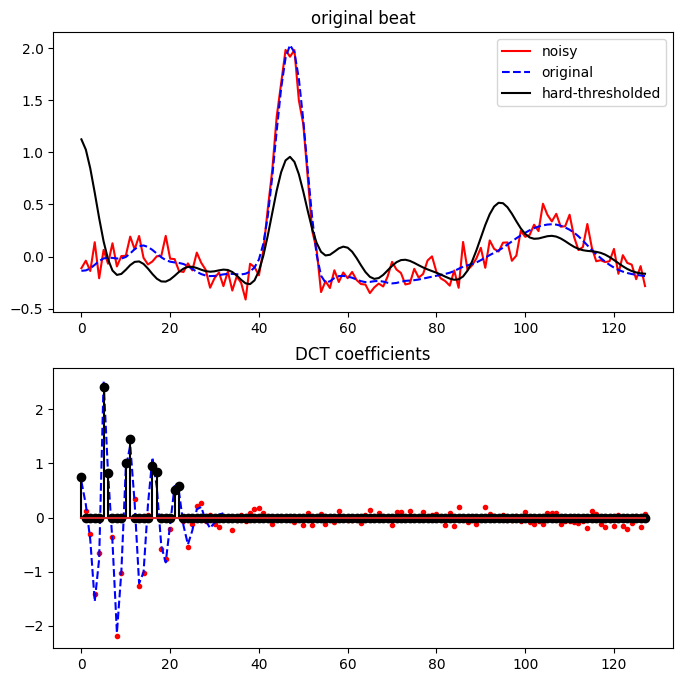

In [119]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
ax1.plot(S[:, i], 'r')
ax1.plot(S0[:, i], 'b--')
ax1.plot(S_hat[:, i], 'k')
ax1.legend(['noisy', 'original', 'hard-thresholded'])
ax1.set_title('original beat')

# coefficients of the noisy signal
ax2.plot(np.matmul(D.T, S[:, i]), 'r.')
# coefficients of the noise free signal
ax2.plot(np.matmul(D.T, S0[:, i]), 'b--')
ax2.stem(np.arange(M), X_HT[:, i], 'k')
ax2.set_title('DCT coefficients');

Compression
-----------
Try to compress a heartbeat using different value of $L$ and plot the mean squared error corresponding to each $L$

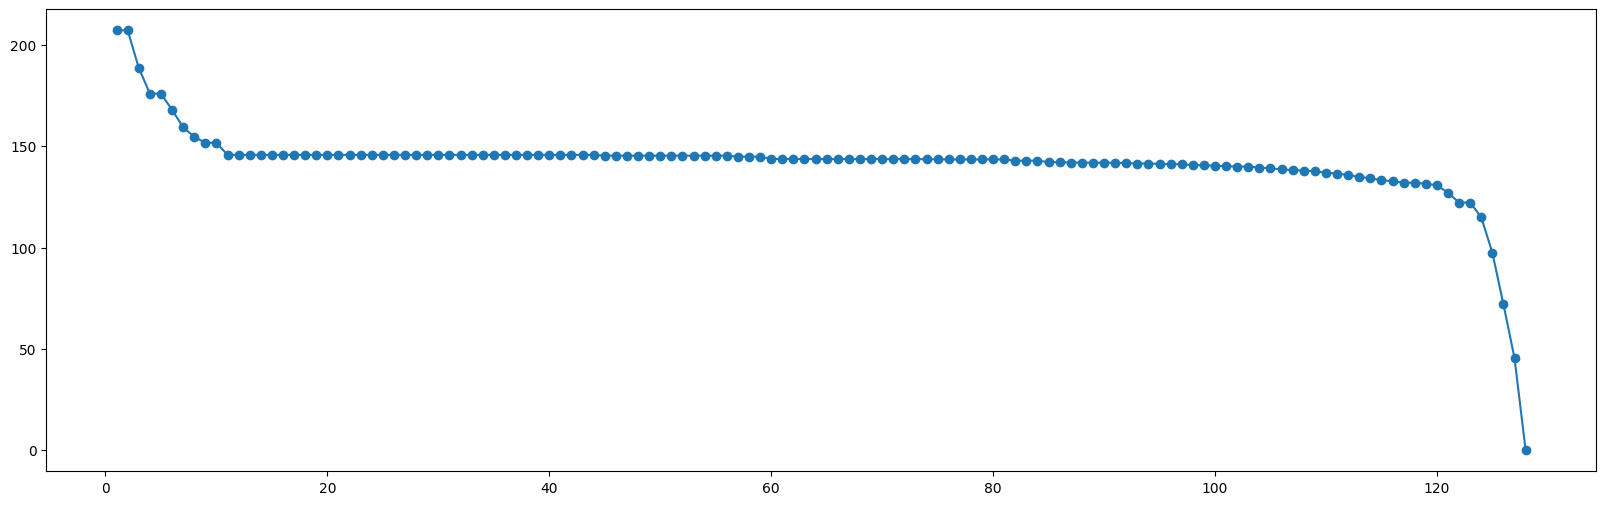

In [122]:
# x_HT = np.zeros((M)) # initialize the matrix of representations of S w.r.t. D
# s_hat = np.zeros((M))

L_values = np.arange(1, M+1)
MSE_values = np.zeros(M)

origSignal = S[:, 0]

for L in L_values:
    S_hat, _ = denoise(X, L)
    MSE_values[L-1] = np.sum(np.square(S_hat - S))

plt.figure(figsize=(20,6))
plt.plot(L_values, MSE_values, '-o');